In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import linregress

In [31]:
metab_file_grouping = pd.read_csv(r'..\data\metadata\20210831_KAO_HILIC_Huishi_sequence.csv',
                               skiprows=1)
metab_file_grouping['analytical_order'] = list(range(0,69))
metab_file_grouping = metab_file_grouping[['File Name', 'analytical_order']]

bad_file = '20210831_KAO_HILIC_ACN'  # file size is only 800 kB and it failed to convert in MSConvert
typo_files = {'20210831_KAO_HILIC_T193M20210406_9wk_RBG': '20210831_KAO_HILIC_T1093M_20210406_9wk_RBG',
              '20210831_KAO_HILIC_T1092_20210410_10wk_FBG': '20210831_KAO_HILIC_T1092M_20210410_10wk_FBG',
              '20210831_KAO_HILIC_T112M_20210330_8wk_RBG': '20210831_KAO_HILIC_T1102M_20210330_8wk_RBG',
              '20210831_KAO_HILIC_T1092M_20210402_wk_FBG': '20210831_KAO_HILIC_T1092M_20210402_9wk_FBG'}
qc_files = metab_file_grouping[metab_file_grouping['File Name'].str.contains('human')]['File Name'].to_list()
blank_files = ['20210831_KAO_HILIC_ACN', '20210831_KAO_HILIC_ACN_20210831232610',
               '20210831_KAO_HILIC_extraction_blank_1', '20210831_KAO_HILIC_extraction_blank_1_20210901004002']

def fix_filename(original_filename):
    if original_filename in typo_files:
        return typo_files[original_filename]
    else:
        return original_filename

metab_file_grouping['fixed_filename'] = metab_file_grouping['File Name'].apply(fix_filename)

metab_file_grouping['qc_file'] = metab_file_grouping['File Name'].isin(qc_files)
metab_file_grouping['quant_file'] = metab_file_grouping['fixed_filename'].str.contains('HILIC_T')
metab_file_grouping['blank_file'] = metab_file_grouping['File Name'].isin(blank_files)
metab_file_grouping = metab_file_grouping.drop(0)  # File is 800 kB and doesn't open

metab_file_grouping['animal'] = metab_file_grouping['fixed_filename'].str.split('HILIC_T').str[1].str.split('M_2021').str[0]
metab_file_grouping['week'] = metab_file_grouping[metab_file_grouping['quant_file'] == True]\
                                 ['fixed_filename'].str.split('wk_').str[0].str.split('_').str[-1]
metab_file_grouping['bg_type'] = metab_file_grouping[metab_file_grouping['quant_file'] == True]\
                                   ['fixed_filename'].str.split('_').str[-1]

tf_quant_files = metab_file_grouping[metab_file_grouping['quant_file'] == True]['File Name'].to_list()
metab_file_grouping

,File Name,analytical_order,fixed_filename,qc_file,quant_file,blank_file,animal,week,bg_type
1,20210831_KAO_HILIC_ACN_20210831232610,1,20210831_KAO_HILIC_ACN_20210831232610,False,False,True,NaN,NaN,NaN
2,20210831_KAO_HILIC_extraction_blank_1,2,20210831_KAO_HILIC_extraction_blank_1,False,False,True,NaN,NaN,NaN
3,20210831_KAO_HILIC_extraction_blank_1_20210901...,3,20210831_KAO_HILIC_extraction_blank_1_20210901...,False,False,True,NaN,NaN,NaN
4,20210831_KAO_HILIC_human_plasma_1,4,20210831_KAO_HILIC_human_plasma_1,True,False,False,NaN,NaN,NaN
5,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,5,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,False,True,False,1060,9,RBG
...,...,...,...,...,...,...,...,...,...
64,20210831_KAO_HILIC_T1060M_20210408_10wk_RBG,64,20210831_KAO_HILIC_T1060M_20210408_10wk_RBG,False,True,False,1060,10,RBG
65,20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,65,20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,False,True,False,1102,8,FBG
66,20210831_KAO_HILIC_T1074M_20210322_8wk_FBG,66,20210831_KAO_HILIC_T1074M_20210322_8wk_FBG,False,True,False,1074,8,FBG
67,20210831_KAO_HILIC_T1082M_20210401_9wk_RBG,67,20210831_KAO_HILIC_T1082M_20210401_9wk_RBG,False,True,False,1082,9,RBG


In [81]:
tf = pd.read_excel(r'..\data\raw\metabolomics\20210904_KAO_Huishi_HILIC_Tracefinder_peakAreas.xlsx',
                   index_col=0)

# Some columns have notes in them. Others have strange characters. Others have distracting D / L labels
fixed_metab_names = {
    "Acetyl-L-carnitine": 'Acetylcarnitine',
    "Adenosine 5'-monophosphate": 'Adenosine monophosphate',
    "Cytidine 5'-diphosphocholine": 'Cytidine diphosphocholine',
    "DL-Carnitine": 'Carnitine',
    "DL-Glutamine": 'Glutamine',
    "DL-Leucine/Isoleucine": 'Leucine/Isoleucine',
    "DL-Lysine": 'Lysine',
    "DL-Proline": 'Proline',
    "Guanosine: all right MS2": 'Guanosine',
    "L-(+)-Arginine": 'Arginine',
    "L-(+)-Citrulline": 'Citrulline',
    "L(+)-Ornithine": 'Ornithine',
    "L-Alanine": 'Alanine',
    "L-Aspartic acid": 'Aspartic acid',
    "L-Glutamic acid": 'Glutamic acid',
    "L-Iditol to Six-carbon sugar alcohol": 'Iditol',
    "L-Phenylalanine": 'Phenylalanine',
    "L-Serine": 'Serine', 
    "L-Tyrosine": 'Tyrosine',
    "L-Valine": 'Valine',
    "O-Butyryl-L-carnitine": 'Butyrylcarnitine',
    "O-Isovaleryl-L-carnitine: rt a little shift": 'Isovalerylcarnitine',
    "α-Lactose": 'Lactose'
}

tf = tf.rename(fixed_metab_names, axis=1)
# for col in tf:
#     display(tf[col])

# tf.where(tf>10, lambda x: tf.replace(1))

# for i, row in tf.iterrows():
#     print(type(row))
#     for thing in row:
#         print(thing)
#     row = row.replace(0.0, row.min())
#     print(row)

tf_imputed = pd.DataFrame()

for col in tf:
    col_min = tf[col][tf[col].gt(0)].min(0)  # https://stackoverflow.com/questions/51481884/min-value-in-each-column-of-a-data-frame-excluding-zeros
#     print(col_min)
    tf_imputed[col] = tf[col].replace(0, col_min )

tf_imputed.to_csv(r'..\data\interim\tracefinder_imputed_data.csv')

tf_imputed

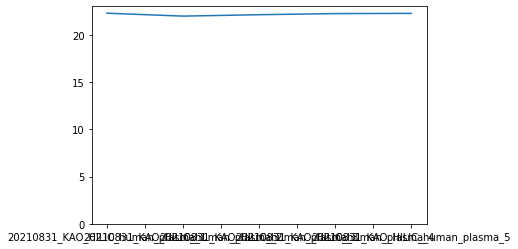

In [21]:
quant = tf[tf.index.isin(metab_file_grouping[metab_file_grouping['quant_file'] == True]['File Name'])]
qc = tf[tf.index.isin(metab_file_grouping[metab_file_grouping['qc_file'] == True]['File Name'])]

# Find zeroes
qc[~(qc < 1)]
# Only column "Guanosine: all right MS2" has any zeroes in file 

np.log2(qc).median(axis=1).plot()
plt.ylim(0, 23);

<AxesSubplot:>

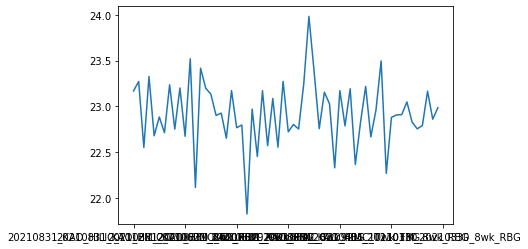

In [15]:
log2quant = np.log2(quant).median(axis=1)
log2quant.plot()


slope:  -0.0006788443306436636
y-intercept:  22.940966206533293
LinregressResult(slope=-0.0006788443306433434, intercept=22.94096620653329, rvalue=-0.03257805942864927, pvalue=0.804826409858866, stderr=0.002734641499292286)


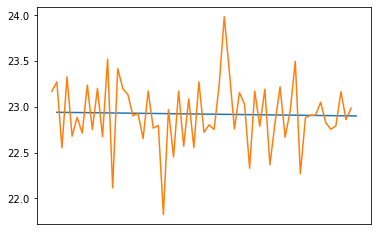

In [165]:
# get linear regression of data
fit = np.polyfit(x=range(1,log2quant.shape[0]+1), y=log2quant, deg=1)
print('slope: ', fit[0])
print('y-intercept: ', fit[1])
print(linregress(np.arange(1, 61), log2quant))
### p-value of 0.8 suggests that there is no need to normalize for intensity drift over time, like we did for lipids

x=np.arange(1, log2quant.shape[0] + 1, dtype='float64')
plt.gca().set_xticks([], [])

plt.plot(x, (fit[0] * x + fit[1]))
plt.plot(log2quant)